In [1]:
# PyTorch Workflow - end to end workflow

In [2]:
covering = {1: "data (prepare and load)",
            2: "build model",
            3: "fitting model to data(training)",
            4: "making predictions",
            5: "save + load",
            6: "put all together"}

In [3]:
import torch
from torch import nn # pytorch building blocks for nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [4]:
# Data Preparing and Loading
# Data = almost anything(excel spreadsheet, Images, Videos, Audio, DNA, Text)
# 1. Get data into numerical representation
# 2. Build a model to learn patterns in that numerical representaion

# Linear Regression to make a straight line with known parameters

In [5]:
weight = 0.7
bias = 0.3

# Create data

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [6]:
# Splitting data into training and test sets

In [7]:
# Create test/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

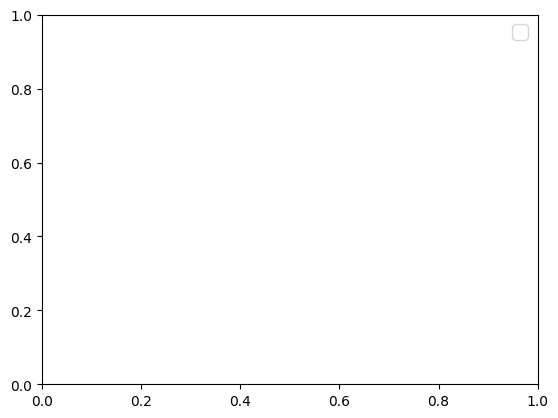

In [8]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s = 4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s = 4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s = 4, label="Predictions")

plt.legend(prop={"size":14})

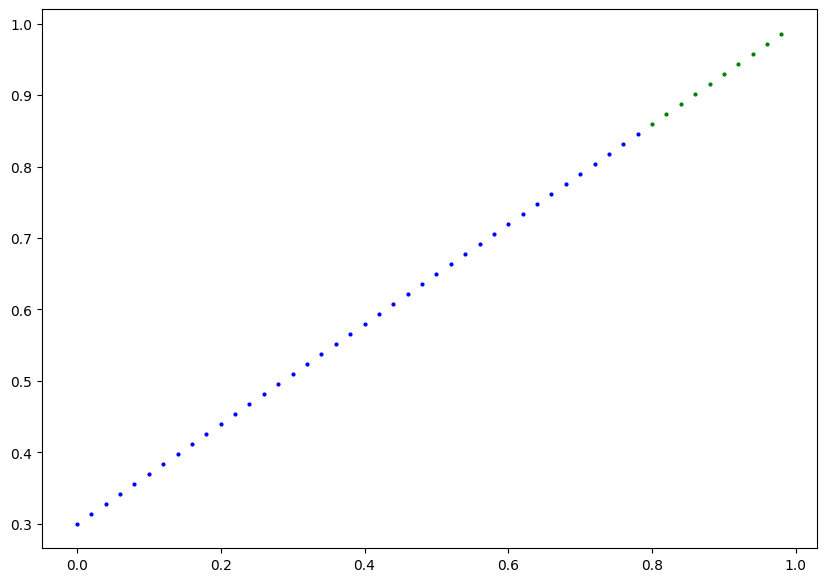

In [9]:
plot_predictions()

In [10]:
# Building a Pytorch model
# What our model does: start with random values weight and bias, look at training data and adjust the random values to get closer to the ideal values(the weight and bias values we used to create the data)
# How does it do so: 1. Gradient descent and 2. Backpropagation

In [11]:
# Create Linear Regression model class

class LinearRegressionModel(nn.Module): #<- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define the computaion in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: #<- "x" is the input data
    return self.weights * x + self.bias

In [12]:
# PyTorch Model building essentials
# torch.nn - contains all the building blocks for computational graphs
# torch.nn.Parameter - what params should out model try and learn
# torch.nn.Module - the base class for all nn modules, if you subclass it you should overwrite forward()
# torch.optim - optimizers in pytorch, help with gradient descent
# def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [13]:
# Checking the contents of our pytorch model
# Check our model params or check what is inside our model with .parameters()

In [14]:
# Create random seed

torch.manual_seed(1234)

# Create an instance of our model

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.0461], requires_grad=True),
 Parameter containing:
 tensor([0.4024], requires_grad=True)]

In [15]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.0461])), ('bias', tensor([0.4024]))])

In [16]:
# Making predictions using torch.inference_mode()
# To check our models predictive power lets check how it predicts x_test and y_test
# When we pass data through out model its goint through the forward method

In [17]:
with torch.inference_mode(): # context manager - inference mode turns off gradient tracking - pytorch is keeping track of less data => faster predictions
  y_preds = model_0(X_test)

y_preds

tensor([[0.4393],
        [0.4402],
        [0.4412],
        [0.4421],
        [0.4430],
        [0.4439],
        [0.4448],
        [0.4458],
        [0.4467],
        [0.4476]])

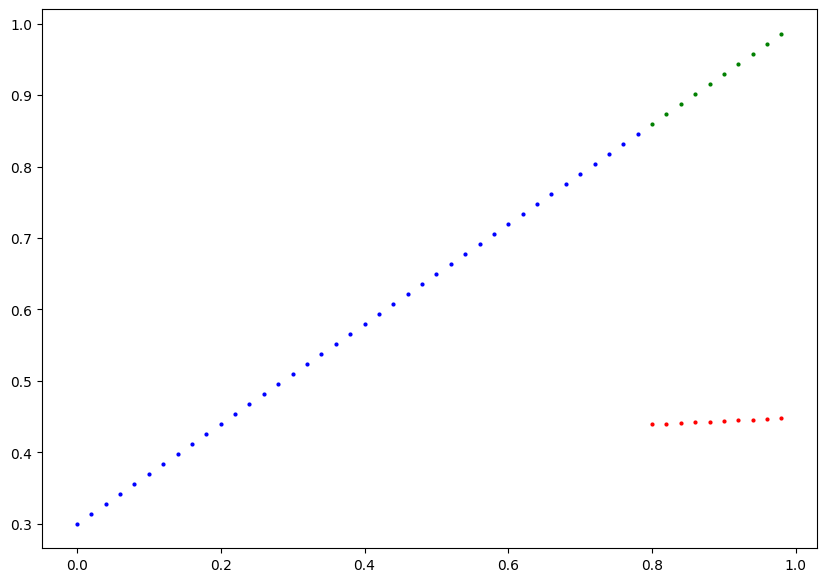

In [18]:
plot_predictions(predictions = y_preds)

In [19]:
# Training the model - the whole idea of training is to get the model to move from some random params to some known parameters
# Poor representaion -> Better representation
# One way to measure how poor or how wrong your models predictions are is to use a loss function
# Loss function may also be called cost funtion or criterion in deifferent areas
# Things we need to train:
# Loss function: A function to mesure how wrong your models predictions are compared with the ideal outputs
# Optimizer: Takes into account the loss of a model and adjusts the models parameters eg werights and bias to improve the loss function
# For pytorch we need a train loop and a testing loop

In [20]:
# Setup loss function

loss_fn = nn.L1Loss()

# Setup optimizer

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.001) #lr = learning rate

In [21]:
# Building a training plus a testing loop in PyTorch
# A couple of things we need in a training loop
# 0. Loop through the data
# 1. Forward pass (this involves data moving through our models forward function) to make predictions - also called forward propagation
# 2. Calculate the loss (compare forward pass predictions to ground truth)
# 3. Optimizer zero grad
# 4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
# 5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)

In [22]:
# An epoch is one loop through the data (hyperparameter because we've set them)
epochs = 5000

epoch_count = []
loss_values = []
test_loss_values = []

# Training

for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients
  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer
  optimizer.step() # by default how the optimizer changes will accumulate through the loop we have to zero them above so it doesnt accumulate and start fresh each loop
  model_0.eval() # turns off different settings not needed for evaluation/testing
  with torch.inference_mode(): # turns off gradient tracking
    # 1. forward pass
    test_pred = model_0(X_test)
    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test)
  # Print out what's happening
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")


Epoch: 0 | Test: 0.175259068608284 | Test loss: 0.47861891984939575
Epoch: 10 | Test: 0.1707487404346466 | Test loss: 0.4697968363761902
Epoch: 20 | Test: 0.16647057235240936 | Test loss: 0.4611462652683258
Epoch: 30 | Test: 0.16249912977218628 | Test loss: 0.4528437554836273
Epoch: 40 | Test: 0.15880891680717468 | Test loss: 0.44477328658103943
Epoch: 50 | Test: 0.1552494317293167 | Test loss: 0.43687963485717773
Epoch: 60 | Test: 0.1521022468805313 | Test loss: 0.4293982982635498
Epoch: 70 | Test: 0.14895504713058472 | Test loss: 0.4219169020652771
Epoch: 80 | Test: 0.14621928334236145 | Test loss: 0.4149734377861023
Epoch: 90 | Test: 0.1435694694519043 | Test loss: 0.4080897271633148
Epoch: 100 | Test: 0.14101549983024597 | Test loss: 0.40138810873031616
Epoch: 110 | Test: 0.13881707191467285 | Test loss: 0.3951113224029541
Epoch: 120 | Test: 0.13661864399909973 | Test loss: 0.38883456587791443
Epoch: 130 | Test: 0.13455162942409515 | Test loss: 0.3828040659427643
Epoch: 140 | Test:

In [23]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3010]))])

In [24]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8608],
        [0.8748],
        [0.8888],
        [0.9028],
        [0.9168],
        [0.9308],
        [0.9448],
        [0.9588],
        [0.9728],
        [0.9868]])

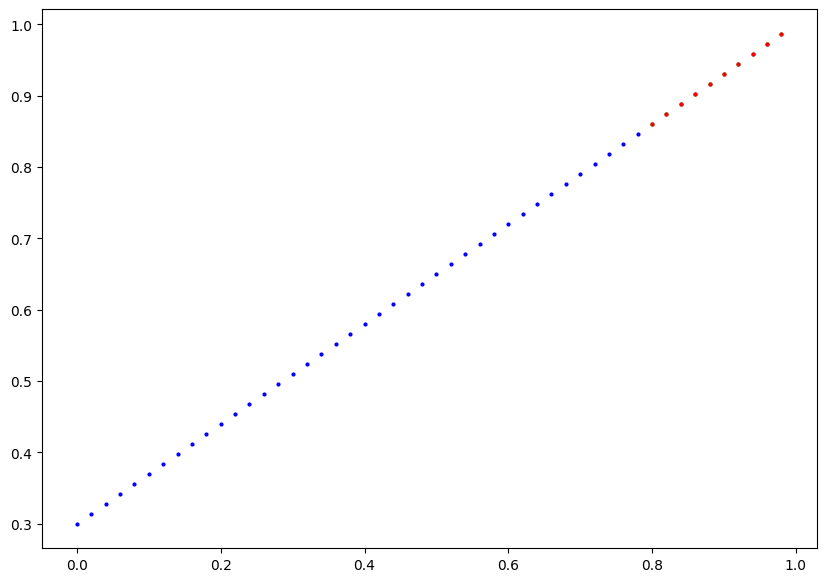

In [25]:
plot_predictions(predictions = y_preds)

In [26]:
# Plot the loss curves
epoch_count, loss_values, test_loss_values

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

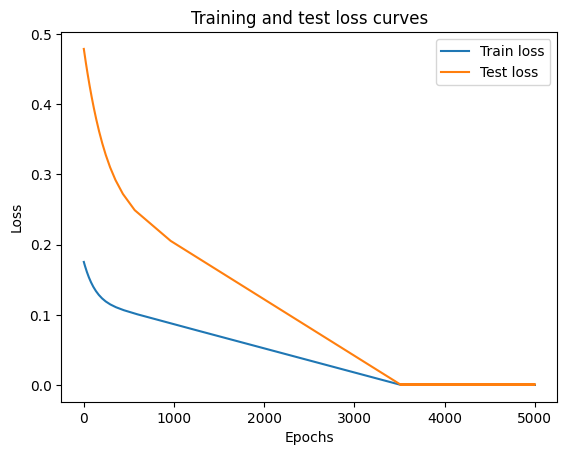

In [27]:
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [28]:
# Saving a model in pytorch

# 3 main methods for saving and loading models in pytorch
# 1 - torch.save() - save pytorch object in pythons pickle format
# 2 - torch.load() - load a saved pytorch object
# 3 - torch.nn.Module.load_state_dict() - load the models save state dictionary

In [29]:
# Save the model:
import pathlib as path
import torch

# Create model directory
MODEL_PATH = path.Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [30]:
!ls models

01_pytorch_workflow_model_0.pth


In [31]:
# Loading a pytorch model
# Since we saved our models state dict we need to instantiate a new class of our model
MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_0.pth')

In [32]:
loaded_module_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_module_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [33]:
loaded_module_0.state_dict()

OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3010]))])

In [34]:
# Make some predictions
loaded_module_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_module_0(X_test)

loaded_model_preds

tensor([[0.8608],
        [0.8748],
        [0.8888],
        [0.9028],
        [0.9168],
        [0.9308],
        [0.9448],
        [0.9588],
        [0.9728],
        [0.9868]])

In [35]:
#Compare loaded model vs original model
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [1]:
# Putting it all together
import torch
import matplotlib.pyplot as plt
from torch import nn

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Fri Aug  2 09:23:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--